In [ ]:
!pip install gradio
!pip install fpdf

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array
from PIL import Image
from collections import deque, Counter
from google.colab import drive
import gradio as gr
from fpdf import FPDF



In [ ]:
drive.mount('/content/drive')
model = load_model('/content/drive/MyDrive/bestmodelsofar.keras')

Mounted at /content/drive


# flow diagram of preocess and predict function

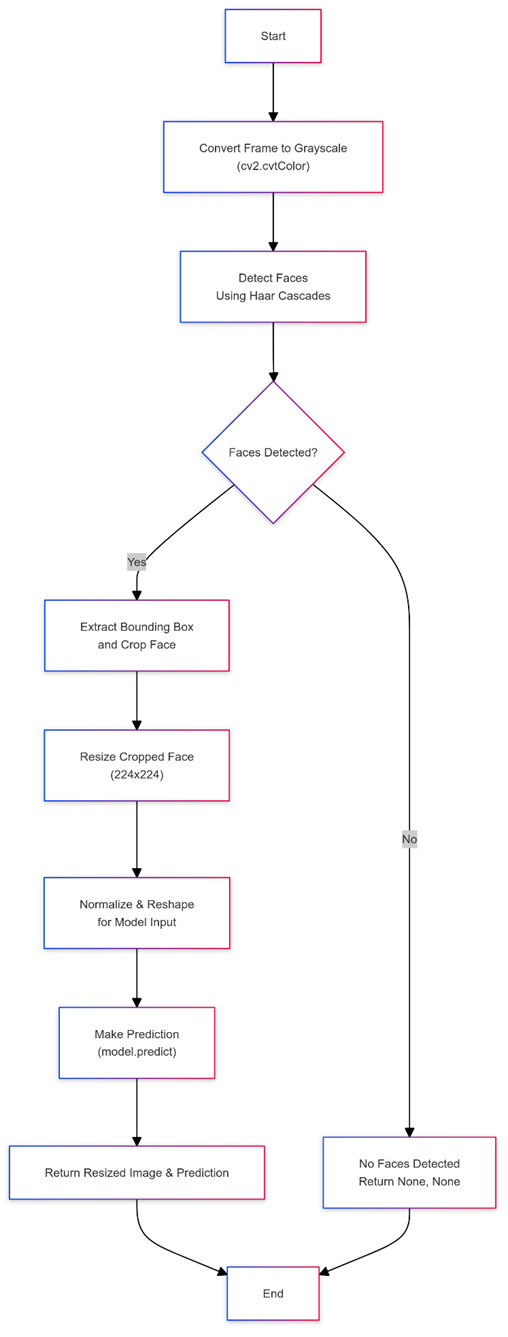

In [ ]:
def preprocess_and_predict(frame, model, face_cascade):
    """
    Detects a face using Haar cascades, crops it, resizes it,
    and predicts the class using the provided model.

    Args:
        frame: The video frame (numpy array).
        model: The pre-trained Keras model.
        face_cascade: The Haar cascade classifier for face detection.

    Returns:
        Tuple: (cropped_image, prediction)
    """

    # Convert frame to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces using Haar cascades
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        # Extract bounding box of the first detected face
        x1, y1, width, height = faces[0]

        # Crop the face
        cropped_img = Image.fromarray(frame[y1:y1 + height, x1:x1 + width])

        # Resize the cropped image
        resized_img = cropped_img.resize((224, 224))
        resized_array = img_to_array(resized_img)
        resized_array = resized_array / 255.0  # Normalize

        # Reshape for model input (assuming a single image prediction)
        input_array = np.expand_dims(resized_array, axis=0)

        # Make prediction
        prediction = model.predict(input_array)

        return resized_img, prediction
    else:
        return None, None



In [ ]:


def smooth_predictions(predictions, window_size=5):
    """
    Smooth predictions by using the mode of the last few predictions.

    Args:
        predictions: List of predictions to smooth.
        window_size: Number of frames to consider for smoothing.

    Returns:
        Smoothed prediction.
    """
    # Determine the actual window size to use
    actual_window_size = min(len(predictions), window_size)

    # Get the most common prediction in the last 'actual_window_size' frames
    most_common_prediction = Counter(predictions[-actual_window_size:]).most_common(1)[0][0]

    return most_common_prediction


# flowdiagram of process video function
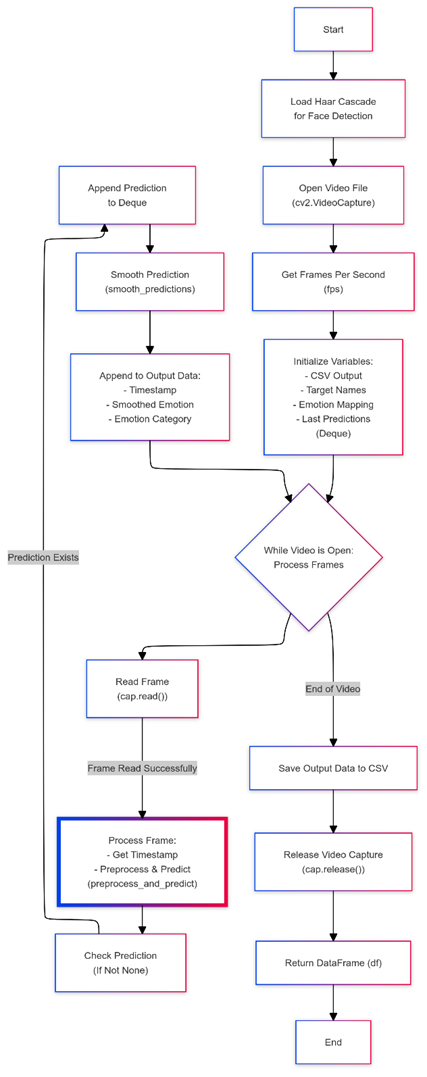

In [ ]:


def process_video(video_path, model, output_csv="output.csv", smoothing_window=5):
    """
    Processes a video, extracting frames at 5 frames per second,
    and saves the time and emotion predictions to a CSV file.

    Args:
        video_path: Path to the video file.
        model: The pre-trained Keras model.
        output_csv: Path to save the output CSV file.
        smoothing_window: Number of frames to consider for smoothing predictions.
    """
    # Load the Haar cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    # Get frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps /2)
    # Prepare the CSV output
    output_data = []
    targetnames = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
    # Define emotion mapping to categories
    emotion_mapping = {
        'angry': 'negative',
        'disgusted': 'negative',
        'fearful': 'negative',
        'sad': 'negative',
        'happy': 'positive',
        'surprised': 'positive',
        'neutral': 'neutral'
    }
    # Store the last few predictions for smoothing
    last_predictions = deque(maxlen=smoothing_window)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Process the frame only if it's the correct interval
        if frame_count % frame_interval == 0:
            timestamp = frame_count / fps  # Get timestamp in seconds
            cropped_img, prediction = preprocess_and_predict(frame, model, face_cascade)
            if prediction is not None:
                predicted_class = np.argmax(prediction)
                emotion = targetnames[predicted_class]
                # Add prediction to the deque and smooth it
                last_predictions.append(emotion)
                smoothed_emotion = smooth_predictions(list(last_predictions))
                emotion_category = emotion_mapping[smoothed_emotion]
                output_data.append([timestamp, smoothed_emotion, emotion_category])
        frame_count += 1
    # Save to CSV
    df = pd.DataFrame(output_data, columns=["Time (s)", "Emotion", "Category"])
    df.to_csv(output_csv, index=False)
    # Release the video capture object
    cap.release()
    return df



In [ ]:


def generate_pdf(line_plot_path, bar_plot_path, pie_chart_path, pdf_path):
    pdf = FPDF()
    logo='/content/drive/MyDrive/university-of-huddersfield-239-logo.png'
    # First Page: Title, Author Info, and Line Graph
    pdf.add_page()
    pdf.set_font("Arial", 'B', 18)
    pdf.cell(0,18,"Report Of Emotion Analysis", 0, 1, 'C')
    pdf.set_y(60)
    pdf.image(logo, x=10, y=None, w=180)
    pdf.set_y(150)
    pdf.set_font("Arial", 'B', 12),
    pdf.multi_cell(0,10, txt=(
        "Emotion Analysis of Your Uploaded Video\n"
        "Created By the Automatic Emotion Detection System"
        "Developed by"
        "Dirdh Prafullkumar Patel"
        "MSc. Artificial Intelligence"
        "University Of HuDdersfield"
        "U2366489"
        "Under The Supervision Of Dr.Tianhua Chen"
    ),align='C')
    # Line Plot
    pdf.add_page()
    pdf.set_font("Arial", 'B', 10)
    pdf.cell(0,10,"I. Graph Of Continuous Emotion in Video Over The Time",0,1, align='C')
    pdf.image(line_plot_path, x=10, y=None, w=180)
    # Bar Plot
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0,10,"II. Bar Plot of Emotion", 0,1,'C')
    pdf.image(bar_plot_path, x=10, y=None, w=180)
    # Footer for Bar Plot Page
    pdf.set_y(265)
    pdf.set_font("Arial", 'I', 8)
    pdf.cell(0,8,'Report Of Emotion Analysis of Video', 0, 1, 'C')
    # Third Page: Pie Chart
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 14, "III. Pie Chart of Emotion Categories",0, 1,'L')
    pdf.image(pie_chart_path, x=10, y=None, w=180)
    pdf.set_font("Arial",'', 8)
    pdf.multi_cell(0,8,txt=(
        "You Can Also Download CSV file for Further Analysis on Website.\n\n"

        "This document has been generated using an AI-based system. "
        "While efforts have been made to ensure accuracy and coherence, "
        "it is important to acknowledge that the content may contain errors "
        "or inconsistencies. Users are advised to review the material carefully "
        "and apply own judgment in evaluating its correctness.\n\n"
    ),align='C')

  # Footer for Bar Plot Page
    pdf.set_y(265)
    pdf.set_font("Arial", 'I', 8)
    pdf.cell(0,8,'Report Of Emotion Analysis of Video', 0, 1, 'C')

    pdf.output(pdf_path)








# flowdiagram of process and display function
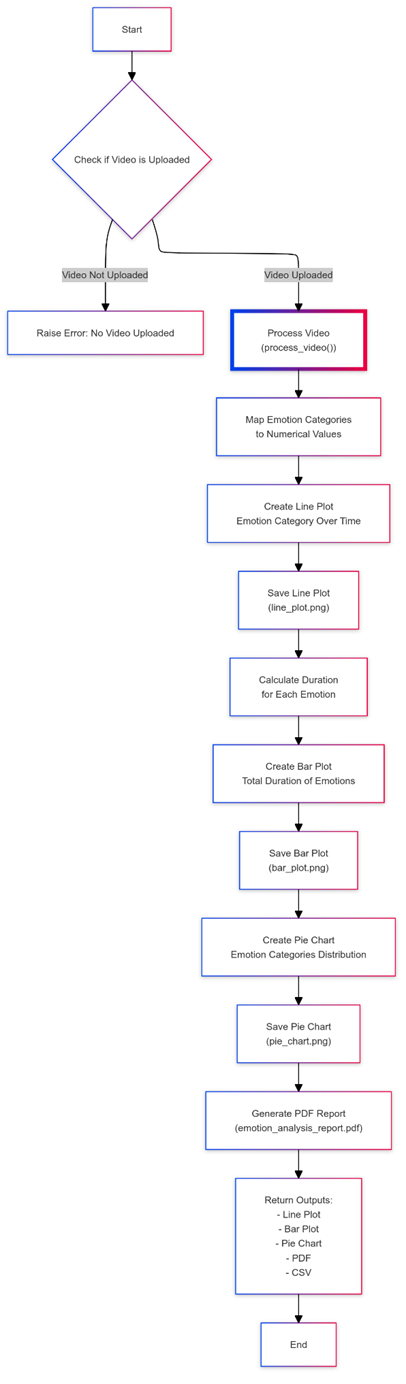

In [ ]:
def process_and_display_video(video_path, model, smoothing_window=5):
    """
    Processes the video, generates predictions, and displays the results in a Gradio interface.
    Returns multiple outputs including plots and a downloadable PDF report.
    """
    # Check if the video is uploaded
    if video_path is None:
        raise ValueError("No video uploaded. Please upload a video before submitting.")
    # Process the video and get predictions
    df = process_video(video_path, model, output_csv="temp_output.csv", smoothing_window=smoothing_window)
    category_mapping = {
        'negative': -1,
        'neutral': 0,
        'positive': 1
    }
    # Apply the mapping to the DataFrame
    df['Category_Num'] = df['Category'].map(category_mapping)
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Time (s)', y='Category_Num', data=df)
    plt.title("Emotion Category Over Time")
    plt.xlabel("Time (Second)")  # Change to seconds if not converting
    plt.ylabel("Category")
    # Set custom y-ticks
    plt.yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
    line_plot_path = "line_plot.png"
    plt.savefig(line_plot_path)
    plt.close()
    # Create a bar plot of emotion counts
    df['Duration'] = df['Time (s)'].diff().shift(-1).fillna(0)
    category_durations = df.groupby('Category')['Duration'].sum()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_durations.index, y=category_durations.values, palette='viridis')
    plt.xlabel('Emotion')
    plt.ylabel('Total Duration (seconds)')
    plt.title('Total Duration of Each Emotion Category')
    plt.xticks(rotation=45)
    bar_plot_path = "bar_plot.png"
    plt.savefig(bar_plot_path)
    plt.close()
    # Create a pie chart of emotion categories
    category_counts = df['Category'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Emotion Categories Distribution')
    pie_chart_path = "pie_chart.png"
    plt.savefig(pie_chart_path)
    plt.close()
    # Generate PDF report
    pdf_path = "emotion_analysis_report.pdf"
    generate_pdf(line_plot_path, bar_plot_path, pie_chart_path, pdf_path)
    # Return the video, DataFrame, line plot, bar plot, pie chart, CSV file, and PDF report
    return line_plot_path, bar_plot_path, pie_chart_path, pdf_path, "temp_output.csv"


# Gradio Interface

In [ ]:
logo='university-of-huddersfield-239-logo.png'
# Create the Gradio interface
inputs = gr.Video(label="Upload Your Video",include_audio=True,min_width=550)
outputs = [
    gr.Image(label="Emotion Trends Over Time"),
    gr.Image(label="Bar Plot of Emotion"),
    gr.Image(label='Pie Chart of Emotion Categories'),
    gr.File(label="Download PDF Report",),
    gr.File(label="Download CSV Data")
]

# Create the Gradio interface
gr_interface = gr.Interface(
    fn=lambda video: process_and_display_video(video, model),
    inputs=inputs,
    outputs=outputs,
    article='This tool is developed by Dirdh Patel(U2366489) for MSc dissertation purposes at the University of Huddersfield Under the supervision of Dr.Tianhua Chen.',
    allow_flagging="never",
    live=True,  # Ensure the video is completely uploaded before processing
)

# Create a Gradio layout with custom CSS
with gr.Blocks() as demo:
    gr.Markdown(
        "<h1 style='text-align: center; margin-bottom: 32px;'>Emotion Recognition from Video</h1>"
    ),
    gr.Image(logo, show_label=False, interactive=False, height=165, show_download_button=False, show_fullscreen_button=False),

    gr.Markdown(
        "<h2 style='text-align: center; margin-bottom: 20px;'>Upload a video from Webcam to analyze the emotions displayed.</h2>"
    ),
    gr.Markdown(
        "<h3 style='text-align: center; margin-bottom: 20px;'>This tool will provide a detailed analysis including visualizations and a downloadable report.</h3>"
    ),
    gr.Markdown(
        "<h3 style='text-align: center; margin-bottom: 20px;color: blue;'>This tool is developed by Dirdh Patel(U2366489) for MSc dissertation purposes at the University of Huddersfield under the supervision of Dr.Tianhua Chen.</h3>"
    ),
    gr_interface.render(),


demo.launch(show_error=True)
